# 뗑컨 몸무게 예측 경진대회

## 패키지 import 및 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/train.csv')

In [3]:
df.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


|변수   |세부사항   |
|:-:|:-:|
|id | 샘플 아이디|
|Species| 펭귄의 종을 나타내는 문자열|
|Island | 샘플들이 수집된 Palmer Station 근처 섬 이름|
|Clutch Completion | 관찰된 펭귄 둥지의 알이 2개인 경우 Full Clutch이며 Yes로 표기|
|Culmen Length (mm) | 펭귄 옆모습 기준 부리의 가로 길이|
|Culmen Depth (mm) | 펭귄 옆모습 기준 부리의 세로 길이|
|Flipper Length (mm) |펭귄의 팔(날개) 길이|
|Sex | 펭귄의 성별|
|Delta 15 N (o/oo)  | 토양에 따라 변화하는 안정 동위원소 15N:14N의 비율|
|Delta 13 C (o/oo) | 먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율|
|Body Mass (g)| 펭귄의 몸무게를 나타내는 숫자 (g)|

`-` 범주형 변수 4개, 양적 변수 6개이다

In [4]:
df.describe().round(2)

,id,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
count,114.00,114.00,114.00,114.00,111.00,111.00,114.00
mean,56.50,44.61,17.01,203.05,8.74,-25.72,4327.85
std,33.05,5.32,1.94,14.65,0.57,0.86,781.77
min,0.00,33.50,13.20,174.00,7.63,-27.02,2700.00
25%,28.25,40.33,15.22,190.00,8.27,-26.43,3675.00
50%,56.50,45.20,17.25,199.00,8.63,-25.96,4250.00
75%,84.75,49.08,18.60,216.00,9.26,-25.01,4850.00
max,113.00,55.10,21.10,231.00,10.03,-24.10,6300.00


In [5]:
df.shape ## 똉컨 114마리에 대한 10가지의 정보

(114, 11)

In [6]:
df.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    3
Delta 15 N (o/oo)      3
Delta 13 C (o/oo)      3
Body Mass (g)          0
dtype: int64

`-` Sex, Delta 15 N, Delta 13 C 컬럼에 결측치가 3개씩 존재한다

In [7]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(df)

결측치가 있는 컬럼은: Sex입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 15 N (o/oo)입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.
결측치가 있는 컬럼은: Delta 13 C (o/oo)입니다
해당 컬럼에 총 3개의 결측치가 존재합니다.


In [8]:
missing_col

[['Sex', dtype('O')],
 ['Delta 15 N (o/oo)', dtype('float64')],
 ['Delta 13 C (o/oo)', dtype('float64')]]

In [9]:
df.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거 

In [10]:
## 결측치가 있는 row들을 확인
df[df.isna().sum(axis = 1) > 0]

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
18,Adelie Penguin (Pygoscelis adeliae),Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650
70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650
109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700


`-` 결측치가 카테고리이면 행을 삭제하고 수치형이면 평균값을 넣어주자

In [11]:
# 결측치를 처리하는 함수 
def handle_na(data, missing_col):
    temp = data.copy()
    for col, dtype in missing_col:
        if dtype == 'O':
            # 카테고리형 feature가 결측치인 경우 해당 행들을 삭제
            temp = temp.dropna(subset=[col])
        elif dtype == int or dtype == float:
            # 수치형 feature가 결측치인 경우 평균값을 채움
            temp.loc[:,col] = temp[col].fillna(temp[col].mean())
    return temp

In [12]:
df = handle_na(df, missing_col)

In [13]:
# 결측치 처리가 잘 되었는지 확인
missing_col = check_missing_col(df) 

결측치가 존재하지 않습니다


In [14]:
df.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

## 모델링

### 전처리

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
dt = df.iloc[:, :-1]      ## target 제외한 데이터프레임
target = df['Body_Mass']  ## target

`-` 범주형 변수에 라벨인코딩을 해주자

In [17]:
from sklearn.preprocessing import LabelEncoder

dt2 = dt.copy()
for col in dt.columns:
    if dt.dtypes[col] == 'O':
        encoder = LabelEncoder()
        encoder.fit(dt[col])
        labels = encoder.transform(dt[col])
        dt2[col] = list(labels) 

In [18]:
dt2.head()  ## 라벨 인코딩이 잘 되었다

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
1,1,1,0,49.5,19.0,200,1,9.63074,-24.34684
2,2,0,1,45.1,14.4,210,0,8.51951,-27.01854
3,2,0,1,44.5,14.7,214,0,8.20106,-26.16524
4,2,0,0,49.6,16.0,225,1,8.38324,-26.84272


In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(dt2, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt2['Species'] , random_state = 21)
## 종의 비율이 train, valid 비슷하도록 세팅함

`-` 위의 split한 데이터프레임을 reset_index 하게 되면 기존의 인덱스번호가 초기화됨을 잊지말자 

## 랜덤 포레스트

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
def RMSE(real, predict):
    return np.sqrt(np.mean(np.square(real - predict)))

In [26]:
model = RandomForestRegressor(random_state = 21)     ## 랜덤 포레스트 모델 선언
model.fit(x_train, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(x_valid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 319.28757311838194


`-` RMSE는 약 319이다

### 모델 성능 시각화

In [28]:
import matplotlib.pyplot as plt

In [29]:
y_predict

array([4216.25, 3428.25, 3593.75, 4151.  , 4618.75, 4236.5 , 4766.  ,
       4171.  , 4205.25, 5127.25, 4176.75, 4149.25, 4846.25, 4055.  ,
       3634.75, 4940.25, 3404.25, 3637.25, 5403.75, 4662.25, 5387.5 ,
       5466.5 , 4801.75])

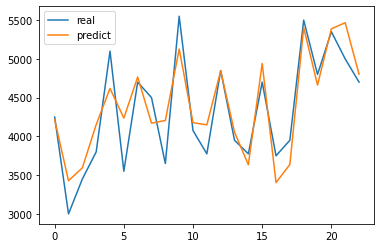

In [30]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` 그럭저럭 잘 맞추는 것 같다

### feature 중요도 시각화

`-` feature_importances를 담은 데이터프레임을 만들자

In [31]:
model.feature_importances_

array([0.30041051, 0.00227972, 0.00089773, 0.04522978, 0.05123867,
       0.44623878, 0.08612741, 0.03838731, 0.02919009])

In [32]:
x_train.columns

Index(['Species', 'Island', 'Full_Clutch', 'Culmen_Length', 'Culmen_Depth',
       'Flipper_Length', 'Sex', 'DeltaN', 'DeltaC'],
      dtype='object')

In [33]:
importance = pd.DataFrame({'col_name':x_train.columns, 'importance':model.feature_importances_})
importance

,col_name,importance
0,Species,0.300411
1,Island,0.002280
2,Full_Clutch,0.000898
3,Culmen_Length,0.045230
4,Culmen_Depth,0.051239
5,Flipper_Length,0.446239
6,Sex,0.086127
7,DeltaN,0.038387
8,DeltaC,0.029190


<AxesSubplot:ylabel='col_name'>

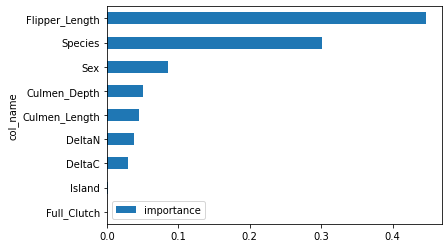

In [34]:
importance.sort_values('importance', ascending = True).\
set_index('col_name').\
plot.barh()

`-` 일단 중요도들의 합은 $1$이다

`-` Island와 Full_Cluth 변수는 중요도가 $0$이다

`-` 중요도가 $0$인 변수를 제외하고 랜덤 포레스트 모델을 만들어보자

## 랜덤 포레스트 (중요하지 않은 변수 제거)

In [35]:
## 중요도가 0인 feature와 방사성 동위원소 feature 제거
Xtrain = x_train.drop(['Full_Clutch', 'Island', 'DeltaN', 'DeltaC'], axis = 1)
Xvalid = x_valid.drop(['Full_Clutch', 'Island', 'DeltaN', 'DeltaC'], axis = 1)

In [36]:
model = RandomForestRegressor(random_state = 21)     ## 랜덤 포레스트 모델 선언
model.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 331.4706033263964


### 모델 성능 시각화

In [154]:
y_predict

array([4139.5 , 3479.25, 3576.75, 4068.  , 4555.75, 4265.25, 4704.5 ,
       4493.5 , 4230.75, 5286.5 , 4235.  , 4115.25, 4809.75, 3892.  ,
       3574.75, 5004.75, 3367.25, 3575.75, 5676.5 , 4748.5 , 5560.  ,
       5577.5 , 4773.75])

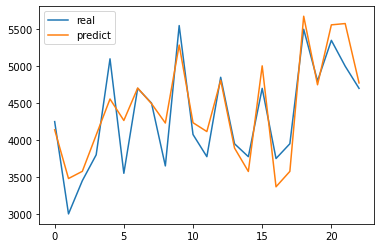

In [155]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` 그럭저럭 잘 맞추는 것 같다

## 랜덤 포레스트 (Species, Flipper_Length 선택)

In [180]:
Xtrain = x_train[['Species', 'Flipper_Length']]
Xvalid = x_valid[['Species', 'Flipper_Length']]

In [181]:
model = RandomForestRegressor(random_state = 21)     ## 랜덤 포레스트 모델 선언
model.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 380.46922238082414


`-` RMSE는 약 380이다

### 모델 성능 시각화

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
y_predict

array([3615.375     , 3694.69464286, 3646.9462031 , 4021.63404651,
       4572.84821429, 3525.79166667, 4490.90079365, 4400.5       ,
       4021.63404651, 4773.75      , 4327.59166667, 4083.45833333,
       4582.59821429, 3733.        , 3706.85416667, 5403.63888889,
       4083.45833333, 3706.85416667, 5481.5       , 4496.4202381 ,
       5495.21666667, 5465.55      , 4773.75      ])

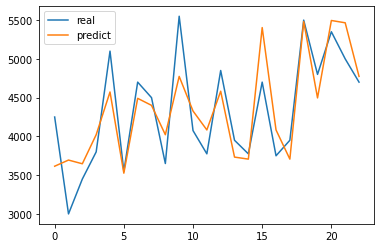

In [184]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` 그럭저럭 잘 맞추는 것 같다

## 랜덤 포레스트 하이퍼 파라미터 변경

### Species, Flipper_Length, Sex 사용

In [262]:
Xtrain = x_train[['Species', 'Flipper_Length', 'Sex']]
Xvalid = x_valid[['Species', 'Flipper_Length', 'Sex']]

In [373]:
model = RandomForestRegressor(random_state = 21,
                              min_samples_leaf = 2,
                              min_samples_split = 32,
                              max_depth = 4)     ## 랜덤 포레스트 모델 선언
model.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)     ## 평가 지수 
print('RMSE', rmse)

RMSE 280.3030939215372


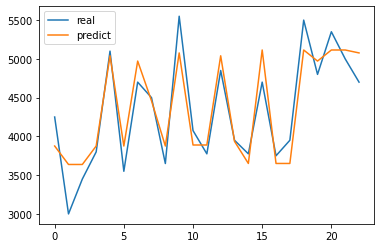

In [374]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

`-` 성능이 더 좋아진것 같다

`-` RMSE도 280이 됐다

In [375]:
model.feature_importances_

array([0.40998804, 0.54711062, 0.04290134])

In [376]:
Xtrain.columns

Index(['Species', 'Flipper_Length', 'Sex'], dtype='object')

In [377]:
importance = pd.DataFrame({'col_name':Xtrain.columns, 'importance':model.feature_importances_})

<AxesSubplot:ylabel='col_name'>

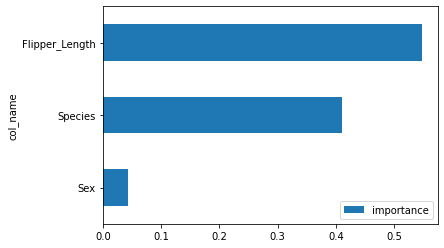

In [378]:
importance.sort_values('importance', ascending = True).\
set_index('col_name').\
plot.barh()

### Species, Flipper_Length사용

In [379]:
Xtrain = x_train[['Species', 'Flipper_Length']]
Xvalid = x_valid[['Species', 'Flipper_Length']]

In [406]:
model = RandomForestRegressor(random_state = 21,
                              min_samples_leaf = 1,
                              min_samples_split = 27,
                              max_depth = 3)     ## 랜덤 포레스트 모델 선언
model.fit(Xtrain, y_train)         ## 랜덤 포레스트 모델 학습
y_predict = model.predict(Xvalid)  ## 모델 예측
rmse = RMSE(y_predict, y_valid)    ## 평가 지수 
print('RMSE', rmse)

RMSE 278.6463875041205


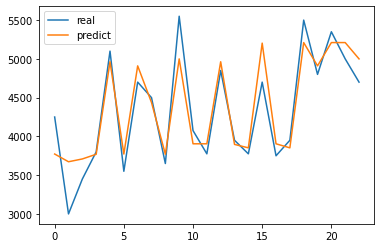

In [398]:
real = pd.DataFrame(y_valid.reset_index()).drop('index', axis = 1)
plt.plot(real, label = 'real')
plt.plot(y_predict, label = 'predict')
plt.legend()

### test 데이터 예측

In [403]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [404]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

`-` test 데이터에 NA가 존재하나 Species, Flipper_Length만 사용할 것이므로 괜찮다

In [405]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

`-` test 셋에서 범주형 변수에 라벨인코딩을 해주자

In [408]:
test2 = test.copy()
for col in test.columns:
    if test.dtypes[col] == 'O':
        encoder = LabelEncoder()
        encoder.fit(test[col])
        labels = encoder.transform(test[col])
        test2[col] = list(labels) 

In [409]:
test2.head()  ## 라벨 인코딩이 잘 되었다

,id,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,0,1,1,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,1,2,0,1,55.9,17.0,228.0,1,8.31180,-26.35425
2,2,0,1,1,38.9,18.8,190.0,0,8.36936,-26.11199
3,3,1,1,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,4,0,0,0,37.9,18.6,172.0,0,8.38404,-25.19837


In [411]:
testdata = test2[['Species', 'Flipper_Length']]

In [418]:
predict_test = model.predict(testdata)  ## 모델 예측

In [419]:
predict_test[:6]

array([4449.698957  , 5210.36027627, 3769.45950271, 3709.02504428,
       3622.73340479, 3852.32448331])

### dacon 대회에 제출하기

In [417]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')
submission.head()

,id,Body Mass (g)
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [420]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4449.698957
1,1,5210.360276
2,2,3769.459503
3,3,3709.025044
4,4,3622.733405


In [421]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission4.csv', index = False)

`-` 점수는 408.093592646

`-` 내 생각엔 너무 언더피팅한 것 같음

`-` Island와 Full_Clutcht만 제외하자

`-` 했는데 실수로 날려먹음......

`-` 점수는 327.4615887171

## K-Fold Cross Validation (K겹 교차검증)

`-` 데이터가 111개로 적은편이다

`-` test 데이터셋은 훈련에 학습을 시키지 못하는 단점이 있다

`-` 안 그래도 적은 데이터가 더 적어지는 것이다

`-` 이러한 점을 보완하는 방법이 K겹 교차검증이다

`-` 데이터셋을 K등분하여 K-1개는 train, 나머지는 test하는데 사용한다

`-` 이를 K번 반복함으로써 데이터를 전부 사용하기에 정확성이 높아진다

`-`  랜덤포레스트에서 중요도가 거의 $0$인 feature는 제외하여 분석하자

In [39]:
Xtrain = x_train.drop(['Island', 'Full_Clutch'], axis = 1)
Xvalid = x_valid.drop(['Island', 'Full_Clutch'], axis = 1)

In [47]:
X = pd.concat([Xtrain, Xvalid])

In [45]:
Y = pd.concat([y_train, y_valid])

In [41]:
from sklearn.model_selection import cross_val_score ## k겹 교차검증

In [48]:
rf = RandomForestRegressor(random_state = 21,
                           min_samples_leaf = 2,
                           min_samples_split = 18,
                           max_depth = 4)

`-` k겹 교차검증 : https://dacon.io/competitions/open/235698/talkboard/403902?page=1&dtype=recent

`-` 회귀분석할 때 교호작용항 추가해보자